In [1]:
import os
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import anndata as ad
import scCausalVAE as scCVAE
from scCausalVAE.model.scCausalVAE import scCausalVAEModel

scvi.settings.seed = 0
import warnings
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [2]:
file_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/testdata/ifnb_preprocess.h5ad"

In [3]:
adata = ad.read_h5ad(file_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 24679 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'V1', 'V2'

In [5]:
adata = adata[adata.obs['cell'].notna()]

In [6]:
adata

View of AnnData object with n_obs × n_vars = 24673 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'V1', 'V2'

In [7]:
adata.obs['stim'].value_counts()

stim
stim    12358
ctrl    12315
Name: count, dtype: int64

In [8]:
adata.obs['cell'].value_counts()

cell
CD4 T cells          10389
CD14+ Monocytes       5385
B cells               2573
CD8 T cells           2042
NK cells              1993
FCGR3A+ Monocytes     1599
Dendritic cells        432
Megakaryocytes         260
Name: count, dtype: int64

In [9]:
condition_key = 'stim'
batch_key = 'stim'
group_key = 'cell'
n_conditions = len(adata.obs[condition_key].unique())
print(n_conditions)

2


In [10]:
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=100)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=1000,
    layer='counts',
    subset=True,
)

In [11]:
adata.obs['cell'].value_counts()

cell
CD4 T cells          10386
CD14+ Monocytes       5380
B cells               2572
CD8 T cells           2041
NK cells              1992
FCGR3A+ Monocytes     1596
Dendritic cells        432
Megakaryocytes         246
Name: count, dtype: int64

In [12]:
adata.obs['stim'].value_counts()

stim
stim    12346
ctrl    12299
Name: count, dtype: int64

In [13]:
adata

AnnData object with n_obs × n_vars = 24645 × 1000
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes'
    var: 'V1', 'V2', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [14]:
# adata.obs[condition_key]

In [15]:
control_key='ctrl'
conditions = ['ctrl', 'stim',]  # make sure the first one is control data
group_indices_list = [np.where(adata.obs[condition_key]==group)[0] for group in conditions]
scCausalVAEModel.setup_anndata(adata, labels_key=condition_key, layer='counts',)

In [16]:
# adata.obs

In [17]:
condition2int = adata.obs.groupby(condition_key, observed=False)['_scvi_labels'].first().to_dict()
control = condition2int[control_key]

In [18]:
control

0

In [ ]:
model = scCausalVAEModel(
    adata, 
    control=control,
    n_conditions=n_conditions,
    n_layers=2,
    n_treat=n_conditions-1,
    n_background_latent=10,
    n_salient_latent=10,
    mmd_weight=10,
    cls_weight=0,
    mse_weight=0,
    # norm_weight=0.3,
    norm_weight=0.2,
)

In [ ]:
# model.module

In [19]:
import torch
use_gpu = torch.cuda.is_available()

In [ ]:
# model.module

In [20]:
# model.train(
#     group_indices_list,
#     use_gpu=use_gpu,
#     max_epochs=500,
#     early_stopping=True,
# )
model_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/models/scCausalVI"
model_path = os.path.join(model_path, "IFNB_model.pth")
model = torch.load(model_path)

In [21]:
# latent_bg, latent_t = model.get_latent_representation(give_mean=True)
latent_bg, latent_t = model.get_latent_representation()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [22]:
adata.obsm['latent_bg'] = latent_bg
adata.obsm['latent_t'] = latent_t

In [23]:
adata

AnnData object with n_obs × n_vars = 24645 × 1000
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'V1', 'V2', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent_bg', 'latent_t'
    layers: 'counts'

## Visualiza latent data

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


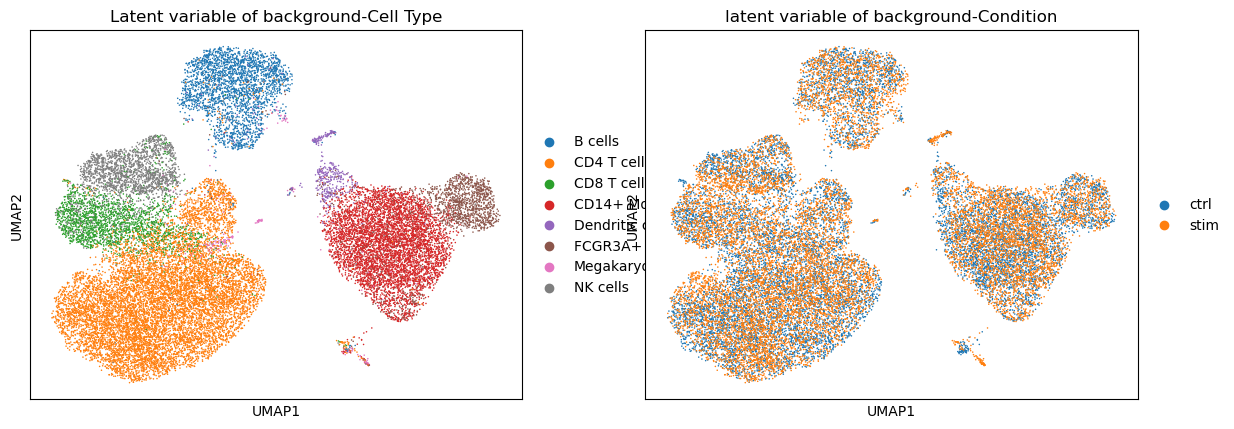

In [24]:
sc.pp.neighbors(adata, use_rep='latent_bg')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[group_key, condition_key], title=['Latent variable of background-Cell Type', 'latent variable of background-Condition'])


In [25]:
adata.obsm['X_umap_bg'] = adata.obsm['X_umap'].copy()

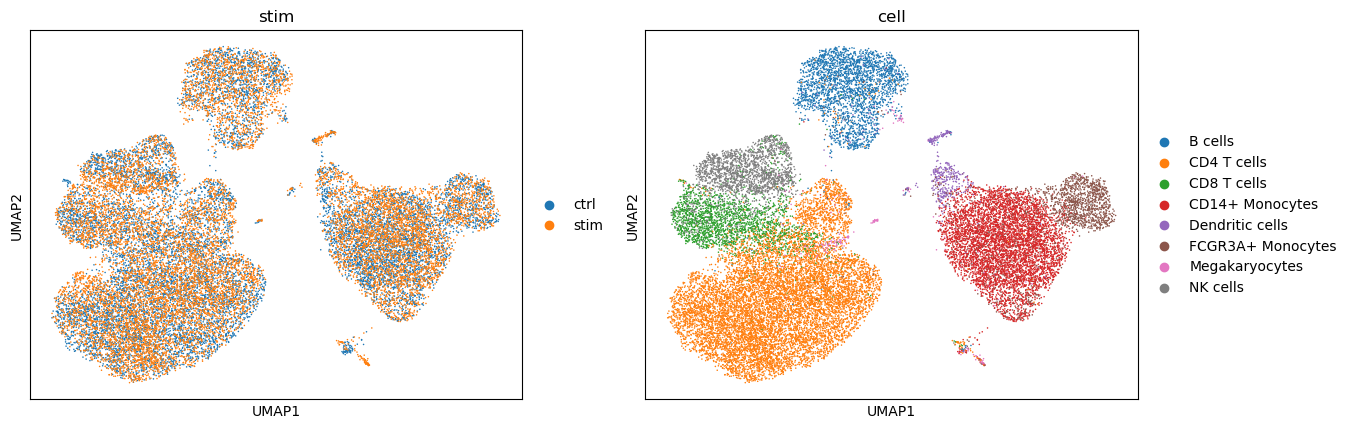

In [26]:
sc.pl.umap(adata, color=['stim', 'cell'])

In [27]:
del adata.uns['stim_colors']

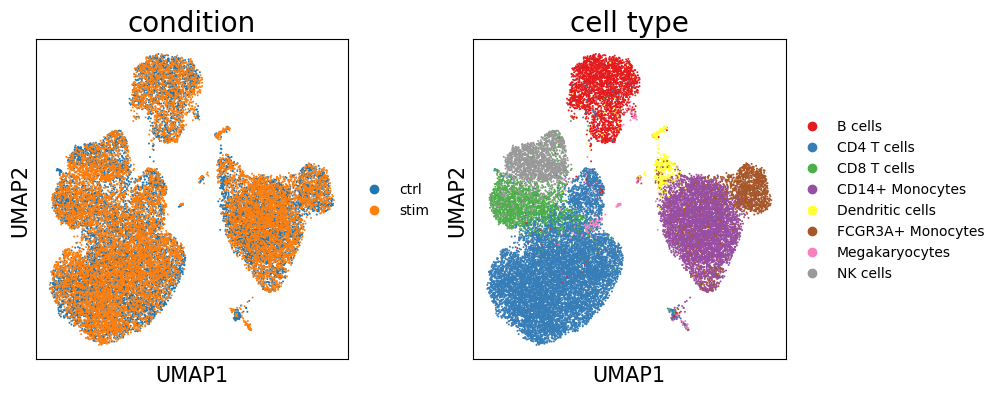

In [28]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.4}, )


sc.pl.embedding(adata, basis="X_umap_bg", color=condition_key, 
                title= "condition", ax=ax1, s=8, show=False, )
sc.pl.embedding(adata, basis="X_umap_bg", color=group_key, 
                title= "cell type", ax=ax2, s=8, show=False, palette='Set1',)
ax1.set_xlabel("UMAP1", fontsize=15)
ax1.set_ylabel("UMAP2", fontsize=15)
ax2.set_xlabel("UMAP1", fontsize=15)
ax2.set_ylabel("UMAP2", fontsize=15)
ax1.set_title('condition', fontsize=20)
ax2.set_title('cell type', fontsize=20)

plt.subplots_adjust(left=0.03, right=0.78, top=0.9, bottom=0.1)
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta"
save_file = os.path.join(save_path, "scCausalVAE_IFNb_confounder.pdf")
# plt.savefig(save_file, dpi=300)

In [29]:
adata_tm1 = adata[adata.obs[condition_key]=='stim'].copy()

In [30]:
# sc.tl.pca(adata_tm1,)
# sc.pl.pca(adata_tm1, color=["cell_type", "condition"])

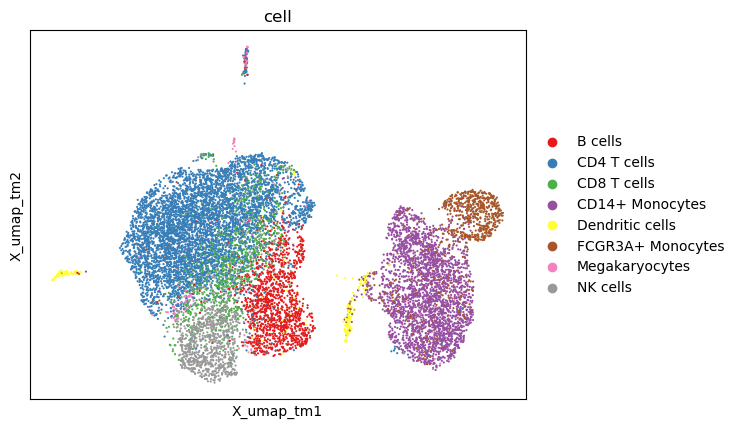

In [61]:
import pickle 
file_path = '/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/results/scCausalVI/IFNB-results.pkl'
with open(file_path, 'rb') as f:
    tt = pickle.load(f)

adata_tm1 = tt['adata_tm1'].copy()
sc.pl.embedding(adata_tm1, basis='X_umap_tm', color='cell')


In [47]:
adata_tm1.obsm['X_umap_tm'] = adata_tm1.obsm['X_umap'].copy()

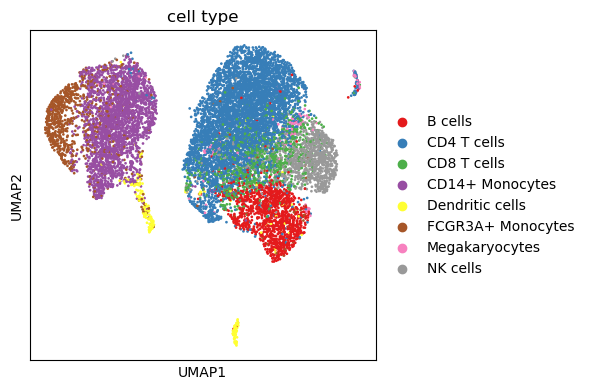

In [48]:
import matplotlib.pyplot as plt
fig, ax= plt.subplots(1, 1, figsize=(6,4), )
sc.pl.embedding(adata_tm1, basis="X_umap_tm", color=group_key, 
                title= "cell type", ax=ax, s=15, show=False, palette='Set1')
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
# plt.subplots_adjust(left=0.03, right=0.78, top=0.9, bottom=0.1)
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVAE_IFNb_treatment.pdf")
plt.tight_layout()
# plt.savefig(save_file, dpi=300)


In [ ]:
import seaborn as sns

sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 4),)
te = ad.AnnData(X=adata_tm1.obsm['latent_t'].copy(),
                obs=adata_tm1.obs.copy(),
               )
te.obs['te'] = np.linalg.norm(te.X, axis=1)

palette = adata_tm1.uns['cell_colors']

# sc.pl.violin(te, keys='te', groupby='cell', rotation=20, show=False, ax=ax, palette='Set2')
sns.violinplot(data=te.obs, x='cell', y='te', ax=ax, palette=palette)

ax.set_ylabel('treatment effect score', fontsize=20)
ax.set_xlabel('')
ax.set_title('treatment effect', fontsize=20)
ax.tick_params(axis='x', labelsize=15, rotation=20)

plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.2)
# plt.tight_layout()

save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVI-treatment effect score.pdf")
# plt.show()
plt.tight_layout()
# plt.savefig(save_file, dpi=300)



In [ ]:
import pickle
results = {"adata": adata, 
           'adata_tm1': adata_tm1,
          }
file_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/results/scCausalVI"
file_path = os.path.join(file_path, "IFNB-results.pkl")
with open(file_path, "wb") as file:
    pickle.dump(results, file)


## Visualize background + treatment effect latent variable 

In [ ]:
adata_tm1.obsm['latent_bg_t'] = np.concatenate((adata_tm1.obsm['latent_bg'],
                                                adata_tm1.obsm['latent_t']), 
                                                axis=1)

In [ ]:
sc.pp.neighbors(adata_tm1, use_rep='latent_bg_t', n_neighbors=30)
sc.tl.umap(adata_tm1, min_dist=0.5)


In [ ]:
sc.pl.umap(adata_tm1, color=[group_key, condition_key], title=["latent backgroound+treatment effect", "latent  backgroudn+treatment effect"])


In [ ]:
adata_tm1.obsm['X_umap_bg_t'] = adata_tm1.obsm['X_umap'].copy()

In [ ]:
adata.obsm['latent_bg_t'] = np.concatenate((adata.obsm['latent_bg'],
                                            adata.obsm['latent_t']), 
                                            axis=1)

In [ ]:
sc.pp.neighbors(adata, use_rep='latent_bg_t', )
sc.tl.umap(adata,)


In [ ]:
sc.pl.umap(adata, color=['stim', 'cell'], palette='Set1')

## Visualize reconstructed data

In [ ]:
reconstructed = model.get_normalized_expression()

In [ ]:
adata_recon = ad.AnnData(X=reconstructed,
                        obs=adata.obs.copy(), 
                        var=adata.var.copy())


In [ ]:
sc.pp.normalize_total(adata_recon, target_sum=1e6)
sc.pp.log1p(adata_recon)
adata_recon.raw = adata_recon
sc.pp.highly_variable_genes(
    adata_recon,
    flavor='seurat',
    n_top_genes=1000,
    subset=True,
)

In [ ]:
adata_recon


In [ ]:
sc.pp.pca(adata_recon)
sc.pp.neighbors(adata_recon, use_rep='X_pca', n_neighbors=100)
sc.tl.umap(adata_recon, min_dist=0.5)

In [ ]:
sc.pl.umap(adata_recon, color=[group_key, condition_key], 
           title=['reconstructed data- cell type', 'reconstructed data - condition'])
# also miss treatment effect

In [ ]:
# import matplotlib.pyplot as plt
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.4}, )
# sc.pl.umap(adata_recon, color=group_key, title= "CellType", ax=ax2, size=8, show=False,)
# sc.pl.umap(adata_recon, color=condition_key, title= "Condition", ax=ax1, size=8, show=False,)
# plt.subplots_adjust(left=0.03, right=0.78, top=0.9, bottom=0.1)
# save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
# save_file = os.path.join(save_path, "scCausalVAE_IFNb_reconstructed.pdf")
# plt.savefig(save_file, dpi=300)
# plt.close()

In [ ]:
recon_count = model.get_count_expression()
recon_count.max()

In [ ]:
adata_recon_count = ad.AnnData(
    X=recon_count,
    obs=adata.obs.copy(),
    var=adata.var.copy(),
)

sc.pp.normalize_total(adata_recon_count, target_sum=1e6)
sc.pp.log1p(adata_recon_count)

In [ ]:
sc.pp.pca(adata_recon_count)
sc.pp.neighbors(adata_recon_count)
sc.tl.umap(adata_recon_count)

In [ ]:
sc.pl.umap(adata_recon_count, color=['stim', 'cell'])

In [ ]:
adata.obs['is_real'] = 'real'
adata_recon_count.obs['is_real'] = 'reconstructed'
adata_recon_count_real = ad.concat([adata, adata_recon_count])

In [ ]:
sc.pp.pca(adata_recon_count_real)
sc.pp.neighbors(adata_recon_count_real)
sc.tl.umap(adata_recon_count_real)

In [ ]:
sc.pl.umap(adata_recon_count_real, color=['stim', 'cell', 'is_real'])

In [ ]:
from tqdm import tqdm
cell_types = adata.obs['cell'].unique().tolist()
pcc_df = pd.DataFrame()
pcc_list = []
for i in tqdm(range(adata.shape[0])):
    real_expression = np.array(adata.X[i, :].todense()).squeeze()
    estimated_expression = adata_recon_count.X[i, :]
    pcc = np.corrcoef(real_expression, estimated_expression)[0, 1]
    pcc_list.append(pcc)
    
    # 将结果添加到DataFrame中


In [ ]:
temp_df = pd.DataFrame({'proportion': [1] * len(pcc_list), 'pcc': pcc_list})

pcc_df = pd.concat([pcc_df, temp_df])
pcc_df

In [ ]:
import seaborn as sns
sns.violinplot(x='proportion', y='pcc', data=pcc_df, inner='box')

## visualize original count data

In [ ]:
adata_ = adata.copy()
sc.pp.pca(adata_)
sc.pp.neighbors(adata_, use_rep='X_pca', n_neighbors=100)
sc.tl.umap(adata_, min_dist=0.5)

In [ ]:
sc.pl.umap(adata_, color=[group_key, condition_key], 
           title=['original data- cell type', 'original data - condition'])
# also miss treatment effect

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.4}, )
sc.pl.umap(adata_, color=group_key, title= "CellType", ax=ax2, size=8, show=False,)
sc.pl.umap(adata_, color=condition_key, title= "Condition", ax=ax1, size=8, show=False,)
plt.subplots_adjust(left=0.03, right=0.78, top=0.9, bottom=0.1)
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVAE_IFNb_original.pdf")
plt.savefig(save_file, dpi=300)
plt.close()

## counterfactual prediciton 

In [ ]:
count_cf, latent_bg_t, _, _, _= model.get_count_expression_counterfactual(
    adata=adata,
    source_condition='ctrl', 
    target_condition='stim',
    condition2int=condition2int,
)

In [ ]:
adata_count_cf = ad.AnnData(
    X=count_cf, 
    obs=adata.obs.copy(),
    var=adata.var.copy()
)
adata_count_cf.obsm['latent_bg_t'] = latent_bg_t

In [ ]:
sc.pp.normalize_total(adata_count_cf, target_sum=1e6)
sc.pp.log1p(adata_count_cf)

In [ ]:
sc.pp.pca(adata_count_cf)
sc.pp.neighbors(adata_count_cf)
sc.tl.umap(adata_count_cf)

In [ ]:
sc.pl.umap(adata_count_cf, color=['stim', 'cell'])

In [ ]:
count_cf2, latent_bg_t2, _, _, _= model.get_count_expression_counterfactual(
    adata=adata,
    source_condition='stim', 
    target_condition='ctrl',
    condition2int=condition2int,
)

In [ ]:
adata_count_cf2 = ad.AnnData(
    X=count_cf2, 
    obs=adata.obs.copy(),
    var=adata.var.copy()
)
adata_count_cf2.obsm['latent_bg_t'] = latent_bg_t2

In [ ]:
sc.pp.normalize_total(adata_count_cf2, target_sum=1e6)
sc.pp.log1p(adata_count_cf2)

In [ ]:
sc.pp.pca(adata_count_cf2)
sc.pp.neighbors(adata_count_cf2)
sc.tl.umap(adata_count_cf2)

In [ ]:
sc.pl.umap(adata_count_cf2, color=['stim', 'cell'])

In [ ]:
adata_count_cf_ctrl = adata_count_cf[adata_count_cf.obs['stim']=='ctrl'].copy()
adata_count_cf_ctrl.obs['is_real'] = "ctrl -> stim"

adata_count_cf2_stim = adata_count_cf2[adata_count_cf2.obs['stim']=='stim'].copy()
adata_count_cf2_stim.obs['is_real'] = 'stim -> ctrl'

adata.obs['is_real'] = ['real '+  t for t in adata.obs['stim']]
adata_cf_real = ad.concat([adata, adata_count_cf_ctrl, adata_count_cf2_stim])
adata_cf_real

In [ ]:
adata

In [ ]:
adata_count_cf_ctrl.var_names

In [ ]:
adata_count_cf_ctrl.var

In [ ]:
sc.pp.pca(adata_cf_real)
sc.pp.neighbors(adata_cf_real)
sc.tl.umap(adata_cf_real)

In [ ]:
sc.pl.umap(adata_cf_real, color=['cell', 'is_real'])

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4), gridspec_kw={'wspace':0.5}, )
sc.pl.umap(adata_cf_real, color='is_real',
           title= "counterfactual prediction", ax=ax1, s=8, show=False, palette='tab20b', alpha=0.3)
sc.pl.umap(adata_cf_real, color='cell', 
           title= "cell type", ax=ax2, s=8, show=False, palette='Set1')
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")
plt.subplots_adjust(left=0.03, right=0.78, top=0.9, bottom=0.1)
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta"
save_file = os.path.join(save_path, "scCausalVAE_IFNb_CF_real_expression.pdf")
plt.savefig(save_file, dpi=300)

In [ ]:
import pickle
results = {"adata_cf_real": adata_cf_real,}
file_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/results/scCausalVI"
file_path = os.path.join(file_path, "IFNB-CF-results.pkl")
with open(file_path, "wb") as file:
    pickle.dump(results, file)


In [ ]:
adata_cf_real

In [ ]:
import pickle 
import os

file_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/results/scCausalVI"
file_path = os.path.join(file_path, "IFNB-CF-results.pkl")
with open(file_path, "rb") as file:
    tt = pickle.load(file)

adata_cf_real = tt['adata_cf_real']

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4), gridspec_kw={'wspace':0.5}, )
sc.pl.umap(adata_cf_real, color='is_real',
           title= "counterfactual prediction", ax=ax1, s=8, show=False, palette='tab20b', alpha=0.3)
sc.pl.umap(adata_cf_real, color='cell', 
           title= "cell type", ax=ax2, s=8, show=False, palette='Set1')
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")
plt.subplots_adjust(left=0.03, right=0.78, top=0.9, bottom=0.1)
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta"
save_file = os.path.join(save_path, "scCausalVAE_IFNb_CF_real_expression.png")
plt.savefig(save_file, dpi=300)

In [ ]:
adata_cf_real

## Counterfactual Prediction and analysis of treatment effect obtained by CF

In [62]:
import torch
import os
import anndata as ad
import scanpy as sc

In [63]:
model_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/models/scCausalVI"
model_path = os.path.join(model_path, "IFNB_model.pth")
model = torch.load(model_path)


In [64]:
file_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/testdata/ifnb_preprocess.h5ad"
adata = ad.read_h5ad(file_path)
adata = adata[adata.obs['cell'].notna()]
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=100)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=1000,
    layer='counts',
    subset=True,
)


In [65]:
scCausalVAEModel.setup_anndata(adata, labels_key='stim', layer='counts')

In [66]:
adata.X.data

array([6.6171703, 6.855269 , 6.762218 , ..., 7.143003 , 6.7308035,
       7.5835714], dtype=float32)

In [67]:
# latent_bg, latent_t = model.get_latent_representation(give_mean=True)
condition2int = adata.obs.groupby('stim', observed=False)['_scvi_labels'].first().to_dict()
condition2int

{'ctrl': 0, 'stim': 1}

In [68]:
adata_ctrl = adata[adata.obs['stim']=='ctrl'].copy()
adata_stim = adata[adata.obs['stim']=='stim'].copy()

In [69]:
adata_ctrl

AnnData object with n_obs × n_vars = 12299 × 1000
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'V1', 'V2', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts'

In [70]:
reconstructed_ctrl_cf, _, _, _, _ = model.get_count_expression_counterfactual(
    adata=adata_ctrl,
    condition2int=condition2int,
    source_condition='ctrl',
    target_condition='stim',
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [71]:
adata_recon_cf = ad.AnnData(
    X=reconstructed_ctrl_cf,
    obs=adata_ctrl.obs.copy(),
    var=adata_ctrl.var.copy(),
)
adata_recon_cf.layers['counts'] = reconstructed_ctrl_cf.copy()


In [72]:
sc.pp.normalize_total(adata_recon_cf, target_sum=1e6)
sc.pp.log1p(adata_recon_cf)

In [73]:
adata_ctrl.X.max(), adata_recon_cf.X.max()

(13.576709, 13.782576)

In [74]:
te = np.array(adata_recon_cf.X-adata_ctrl.X.todense())

In [75]:
adata_te = ad.AnnData(
    X=te, 
    obs=adata_ctrl.obs.copy(),
    var=adata_ctrl.var.copy()
)

In [76]:
sc.pp.pca(adata_te)
sc.pp.neighbors(adata_te)
sc.tl.umap(adata_te)


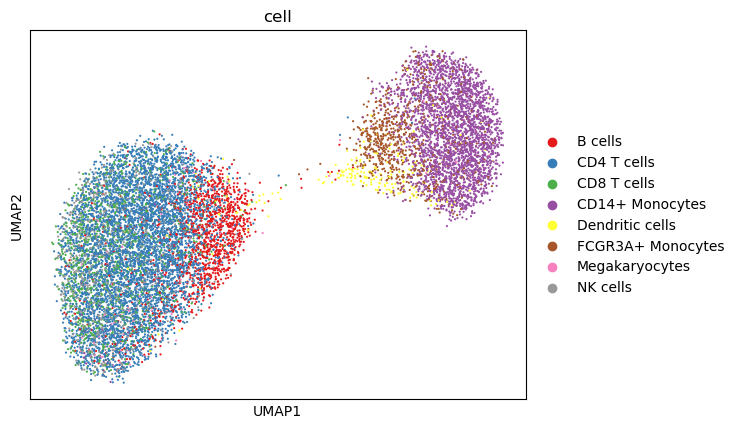

In [77]:
sc.pl.umap(adata_te, color=['cell'], palette='Set1')

In [78]:
import numpy as np
adata_te.obs['te'] = np.linalg.norm(adata_te.X, axis=1)

In [79]:
adata_tm1

AnnData object with n_obs × n_vars = 12346 × 1000
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'V1', 'V2', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'stim_colors', 'cell_colors'
    obsm: 'latent_bg', 'latent_t', 'X_umap', 'X_umap_bg', 'X_umap_tm', 'latent_bg_t', 'X_umap_bg_t'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

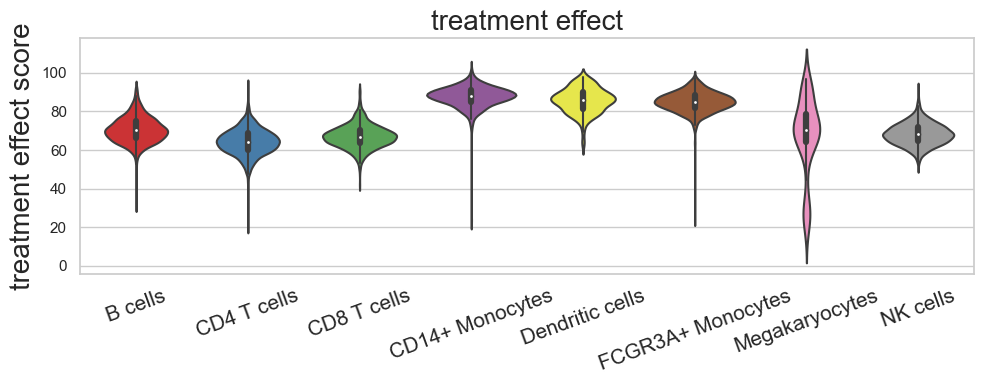

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4),)


# sc.pl.violin(te1, keys='te', groupby='cell_type', rotation=20, show=False, ax=ax1, palette='Set2')
palette = adata_tm1.uns['cell_colors']
sns.violinplot(data=adata_te.obs, x='cell', y='te', ax=ax1, palette=palette)

ax1.set_ylabel('treatment effect score', fontsize=20)
ax1.set_xlabel('')
ax1.set_title('treatment effect', fontsize=20)
ax1.tick_params(axis='x', labelsize=15, rotation=20)

plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.2)
plt.tight_layout() 

save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVI-treatment effect score-gene expression.pdf")

# plt.savefig(save_file, dpi=300)



In [ ]:
adata_stim = adata[adata.obs['stim'] == 'stim'].copy()
adata_stim.obs['is_real'] = 'real stim'
adata_recon_cf.obs['is_real'] = 'ctrl -> stim'

adata_stim_real_cf = ad.concat([adata_stim, adata_recon_cf])

In [ ]:
sc.pp.pca(adata_stim_real_cf)
sc.pp.neighbors(adata_stim_real_cf)
sc.tl.umap(adata_stim_real_cf)


In [ ]:
sc.pl.umap(adata_stim_real_cf, color=['is_real','cell'])

## Permutation test to quantify treatment effect size

For each stimulated cell, we compute the factual prediction (reconstruction) for each cell, and the counterfactual predictin of ctrl condition. The norm of difference between factual prediction and real expression are taken as background, to access if the differecen between real data and CF ctrl data are significant for each cell.

In [81]:
import pickle 
file_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/results/scCausalVI/IFNB-results.pkl"
with open(file_path, 'rb') as file:
    tt = pickle.load(file)

tt

{'adata': AnnData object with n_obs × n_vars = 24645 × 1000
     obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes', '_scvi_batch', '_scvi_labels'
     var: 'V1', 'V2', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'stim_colors', 'cell_colors'
     obsm: 'latent_bg', 'latent_t', 'X_umap', 'X_umap_bg'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 'adata_tm1': AnnData object with n_obs × n_vars = 12346 × 1000
     obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes', '_scvi_batch', '_scvi_labels'
     var: 'V1', 'V2', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'stim_colors', 'cell_colors'
     obsm: 'latent_bg', 'latent_t', 'X_umap', 'X_umap_bg', 'X_umap

In [82]:
adata = tt['adata'].copy()
adata_stim = tt['adata_tm1'].copy()

In [83]:
count_cf_stim, _, _, _, _ = model.get_count_expression_counterfactual(
    condition2int=condition2int,
    source_condition='stim',
    target_condition='ctrl',
    adata=adata_stim,
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [84]:
adata_stim_cf = ad.AnnData(X=count_cf_stim, obs=adata_stim.obs.copy(), var=adata_stim.var.copy())
adata_stim_cf.obs['is_real'] = 'stim -> ctrl'


Compute the factual prediction of stim data, to calculate the background distribution of differnces.

In [85]:
count_stim = model.get_count_expression(
    adata=adata_stim,
)

In [86]:
adata_stim_f = ad.AnnData(X=count_stim, obs=adata_stim.obs.copy(), var=adata_stim.var.copy())
adata_stim_f.obs['is_real'] = 'stim -> stim'


In [87]:
sc.pp.normalize_total(adata_stim_cf, target_sum=1e6)
sc.pp.log1p(adata_stim_cf)

sc.pp.normalize_total(adata_stim_f, target_sum=1e6)
sc.pp.log1p(adata_stim_f)

### Compute treatment effect size on PCA embedding of hig-dimensional data

In [173]:
adata_stim.obs['is_real'] = 'real stim'

stim_real_pred = ad.concat([adata_stim, adata_stim_f, adata_stim_cf])

sc.pp.pca(stim_real_pred, n_comps=20)

diff_null = stim_real_pred[stim_real_pred.obs['is_real'] == "real stim"].obsm['X_pca'] - stim_real_pred[stim_real_pred.obs['is_real'] == "stim -> stim"].obsm['X_pca']

l2_norm_null = np.linalg.norm(diff_null, axis=1)

diff_cf = stim_real_pred[stim_real_pred. obs['is_real'] == "real stim"].obsm['X_pca'] - stim_real_pred[stim_real_pred.obs['is_real'] == "stim -> ctrl"].obsm['X_pca']
l2_norm_cf = np.linalg.norm(diff_cf, axis=1)

# Perform hypothesis testing
# Use the distribution of null hypothesis (l2_norm_null) to test the significance of l2_norm_cf
n = len(diff_null)
p_values = []
for l in l2_norm_cf:
    extreme_count = np.sum(l2_norm_null >= l)
    p_values.append((extreme_count + 1) / (n + 1))

# Apply multi-testing correction (e.g., Benjamini-Hochberg)
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')

significant_cells = np.where(reject)[0]

df = pd.DataFrame({
    "diff_null": l2_norm_null,
    "diff_cf": l2_norm_cf,
})


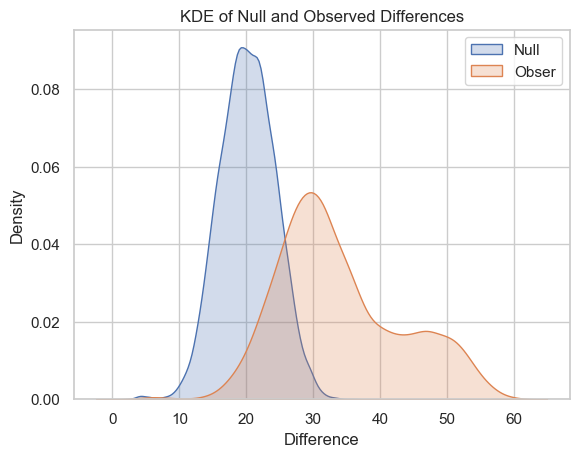

In [174]:
sns.kdeplot(df['diff_null'], fill=True, label='Null')
sns.kdeplot(df['diff_cf'], fill=True, label='Obser')

# Add legend to display labels for each KDE plot
plt.legend()

# Add labels and title if needed
plt.xlabel("Difference")
plt.ylabel("Density")
plt.title("KDE of Null and Observed Differences")

# Show the plot
plt.show()

In [175]:
adata_stim.obs['-log p values'] = -np.log(pvals_corrected +1)
adata_stim.obs['if affected'] = 'False'
adata_stim.obs['if affected'][significant_cells] = 'True'

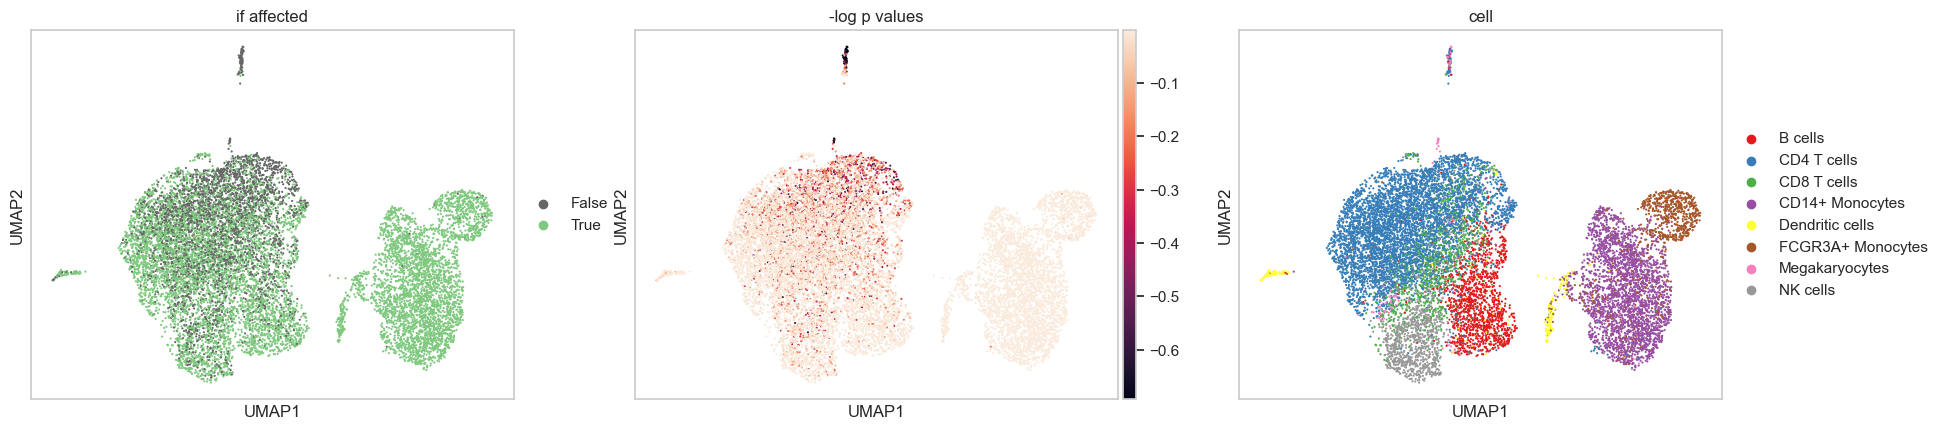

In [176]:
sc.pl.umap(adata_stim, color=['if affected', '-log p values', 'cell'],)

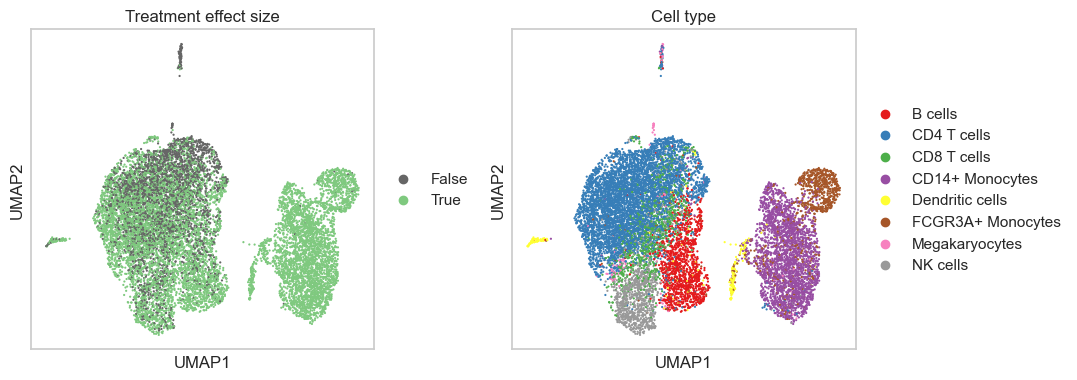

In [179]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4), gridspec_kw={'wspace':0.4}, )
sc.pl.umap(adata_stim, color='if affected', title= "Treatment effect size", ax=ax1, size=10, 
           show=False, palette='Accent_r')
sc.pl.umap(adata_stim, color='cell', title= "Cell type", ax=ax2, size=10, show=False,)
plt.subplots_adjust(left=0.03, right=0.78, top=0.9, bottom=0.1)
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVI-treatment effect size-UMAP.png")
plt.savefig(save_file, dpi=300)
plt.show()

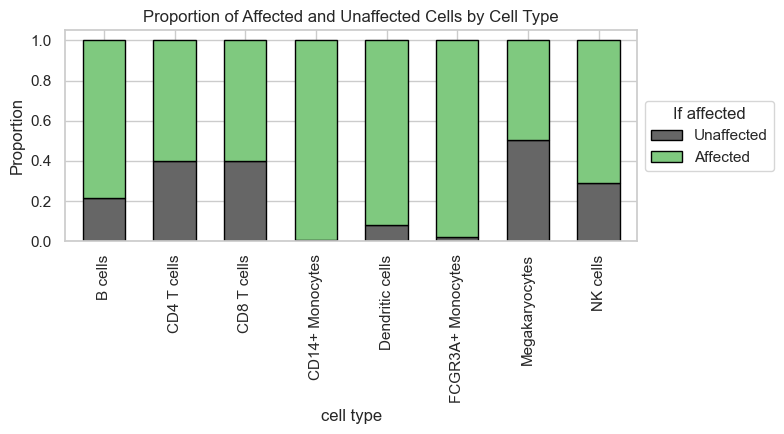

In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming adata.obs contains 'cell_type' and 'if_affected' columns
# Convert to a DataFrame for easier manipulation
df_prop = adata_stim.obs[['cell', 'if affected']]

# Calculate the proportion of affected and unaffected cells for each cell type
proportion_df = df_prop.groupby(['cell', 'if affected']).size().unstack(fill_value=0)
proportion_df = proportion_df.div(proportion_df.sum(axis=1), axis=0)

# Plot the stacked bar chart
proportion_df.plot(kind='bar', stacked=True, colormap='Accent_r', figsize=(8,4.5), 
                   edgecolor='black', width=0.6)

# Add labels and title
plt.xlabel("cell type")
plt.ylabel("Proportion")
plt.title("Proportion of Affected and Unaffected Cells by Cell Type")
plt.legend(title='If affected', labels=['Unaffected', 'Affected'], 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVI-celltype-affected proportion-stackbarplot.pdf")
plt.savefig(save_file, dpi=300)
plt.show()


## compute DE genes based on counterfactual prediction using workflow of scanpy

In [ ]:
import gseapy
import seaborn as sns
from tqdm import tqdm
import statsmodels.stats.multitest as mt
from scipy import stats
from statsmodels.stats.multitest import multipletests


比较基于counterfactual prediction得到的DE genes和用真实的stimulated vs ctrl数据得到的DE genes的区别

In [ ]:

adata_ctrl_cf = adata_recon_cf

adata_ctrl.var_names = adata_ctrl.var['V2'].tolist()
adata_ctrl.obs['is_real'] = 'real ctrl'
adata_ctrl_cf.var_names = adata_ctrl.var['V2'].tolist()
adata_ctrl_cf.obs['is_real'] = 'ctrl -> stim'

adata_ctrl_cf_concat = ad.concat([adata_ctrl, adata_ctrl_cf])

cell_types = adata_ctrl_cf.obs['cell'].unique().tolist()

# DE_ct_cf 
DE_ct_cfvsctrl = {}

for ct in tqdm(cell_types):
    adata_ct = adata_ctrl_cf_concat[adata_ctrl_cf_concat.obs['cell'] == ct].copy()
    sc.tl.rank_genes_groups(
        adata_ct,
        'is_real',
        method='wilcoxon',
        key_added='wilcoxon',
    )
    DE_ct_cfvsctrl[ct] = adata_ct

In [ ]:
n_cell_types = len(cell_types)
n_genes = 5


for i, (cell_type, adata_ct) in enumerate(DE_ct_cfvsctrl.items()):
    plt.figure(figsize=(3, 4))
    sc.pl.rank_genes_groups_heatmap(adata_ct, key='wilcoxon', n_genes=n_genes, cmap='viridis', show=False)
    # sc.pl.rank_genes_groups_dotplot(adata_ct, n_genes=n_genes, key="wilcoxon",)
    # sc.pl.rank_genes_groups_stacked_violin(adata_ct, n_genes=n_genes, key="wilcoxon", )
    # ax.set_title(f"{cell_type}", fontsize=12)
    save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta"
    save_path = os.path.join(save_path, f"DE_genes_heamap_{cell_type}_cf_ctrl.pdf")
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.savefig(save_path, dpi=300)
    plt.close()



In [ ]:
sc.pl.rank_genes_groups_heatmap(DE_ct_stimvsctrl[ct], key='wilcoxon', n_genes=n_genes, cmap='viridis', show=False)

In [ ]:
DE_ct_stimvsctrl[ct].var_names

In [ ]:
adata.var_names = adata.var['V2'].tolist()
del adata.raw

cell_types = adata.obs['cell'].unique().tolist()

# DE_ct_cf 
DE_ct_stimvsctrl = {}

for ct in tqdm(cell_types):
    adata_ct = adata[adata.obs['cell'] == ct].copy()
    sc.tl.rank_genes_groups(
        adata_ct,
        'stim',
        method='wilcoxon',
        key_added='wilcoxon',
    )
    DE_ct_stimvsctrl[ct] = adata_ct
    

In [ ]:
sc.pl.rank_genes_groups_heatmap(DE_ct_stimvsctrl[ct], key='wilcoxon', n_genes=n_genes, cmap='viridis', show=True, )

In [ ]:
n_cell_types = len(cell_types)
n_genes = 5

for i, (cell_type, adata_ct) in enumerate(DE_ct_stimvsctrl.items()):
    plt.figure(figsize=(3, 4))
    sc.pl.rank_genes_groups_heatmap(adata_ct, key='wilcoxon', n_genes=n_genes, cmap='viridis', show=False,)
    # sc.pl.rank_genes_groups_dotplot(adata_ct, n_genes=n_genes, key="wilcoxon",)
    # sc.pl.rank_genes_groups_stacked_violin(adata_ct, n_genes=n_genes, key="wilcoxon", )
    # ax.set_title(f"{cell_type}", fontsize=12)
    save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta"
    save_path = os.path.join(save_path, f"DE_genes_heamap_{cell_type}_stim_ctrl.pdf")
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.savefig(save_path, dpi=300)
    plt.close()



In [ ]:
# sc.pl.rank_genes_groups_heatmap(adata_ctrl_cf_concat, n_genes=5, key="wilcoxon", groupby="cell", show_gene_labels=True)
# sc.pl.rank_genes_groups_dotplot(adata_ctrl_cf_concat, n_genes=5, key="wilcoxon", groupby="cell")
# sc.pl.rank_genes_groups_stacked_violin(adata_ctrl_cf_concat, n_genes=5, key="wilcoxon", groupby="cell")
# sc.pl.rank_genes_groups_matrixplot(adata_ctrl_cf_concat, n_genes=5, key="wilcoxon", groupby="cell")


### 在每个cell type中选择top20的genes, 看看基于counterfactual prediction得到的DE genes和基于real data得到的DE genes的相似性.
### 用这个来验证我们的方法可以正确预测DE genes, 而不是强调CF的方法比真实的数据好!!!


In [ ]:
# use jacard similarity to quantify the overlap 
cell_types = ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes',
              'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes', 'NK cells'
             ]
nums = [5, 10, 20]
overlap_degenes_cts_df = pd.DataFrame(index = cell_types)
for n in nums:
    overlap_degenes_cts = {} 
    for ct in cell_types:
        genes_cf = sc.get.rank_genes_groups_df(
            DE_ct_cfvsctrl[ct], 
            group='ctrl -> stim', 
            key='wilcoxon'
        )['names'][:n]
        genes_real = sc.get.rank_genes_groups_df(
            DE_ct_stimvsctrl[ct], 
            group='stim',
            key='wilcoxon',
        )['names'][:n]
        num_intersection = len(set(genes_cf).intersection(set(genes_real)))
        overlap_degenes_cts[ct] = num_intersection/n
    
    tt = pd.DataFrame({f"n={n}": list(overlap_degenes_cts.values())}, index=list(overlap_degenes_cts.keys()))
    overlap_degenes_cts_df = pd.concat([overlap_degenes_cts_df, tt], axis=1)
    
    
overlap_degenes_cts_df.reset_index(inplace=True)
overlap_degenes_cts_df

In [ ]:
df_long

In [ ]:
df_long = pd.melt(overlap_degenes_cts_df, id_vars=['index'], var_name='Sample Size', value_name='Jaccard Similarity')

palette = adata_tm1.uns['cell_colors']


# 使用Seaborn绘制柱状图
plt.figure(figsize=(10, 3))
sns.barplot(data=df_long, x='Sample Size', y='Jaccard Similarity', hue='index', palette=palette, edgecolor='black')
plt.title('Jaccard Similarity Across Different Cell Types and Gene Sizes')
plt.ylabel('Jaccard Similarity')
plt.xlabel('Sample Size')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVI-DE genes consistency.pdf")
plt.savefig(save_file, dpi=300)

plt.show()

In [ ]:
# 这里的log_fold_change还是计算的平均值, 所以还没有用到数据的成对信息
import seaborn as sns
from tqdm import tqdm
import statsmodels.stats.multitest as mt
from scipy import stats
from statsmodels.stats.multitest import multipletests

adata_ctrl_cf = adata_recon_cf

significance_threshold = 0.01
significance_log_FC = 1.5

adata_ctrl.var_names = adata_ctrl.var['V2'].tolist()
adata_ctrl_cf.var_names = adata_ctrl.var['V2'].tolist()

cell_types = adata_ctrl_cf.obs['cell'].unique().tolist()

DE_ct = {}

for ct in cell_types:
    adata_ctrl_ct = adata_ctrl[adata_ctrl.obs['cell'] == ct].copy()
    adata_ctrl_cf_ct = adata_ctrl_cf[adata_ctrl_cf.obs['cell'] == ct].copy()
    
    data = pd.DataFrame(columns=['p_values_ttest', 'log2_fold_change'])

    p_values_ttest = []
    log2_fold_changes = []
    valid_genes = []
    genes = adata_ctrl.var_names 
    for gene in tqdm(genes):
        control_values = np.array(adata_ctrl_ct[:, gene].X.todense()).squeeze()
        treated_values = adata_ctrl_cf_ct[:, gene].X.squeeze()

        mean_control = np.mean(control_values)
        mean_treated = np.mean(treated_values)
        if mean_control == 0:
            continue
        
        t_stat, p_value_ttest = stats.ttest_ind(control_values, treated_values)
        p_values_ttest.append(p_value_ttest)
        
        log2_fc = np.log2(mean_treated / mean_control)
        log2_fold_changes.append(log2_fc)
        valid_genes.append(gene)

    data = pd.DataFrame({
        'p_values_ttest': p_values_ttest,
        'log2_fold_change': log2_fold_changes
    }, index=valid_genes)


    _, corrected_p_values = mt.fdrcorrection(
        data['p_values_ttest'],
        alpha=0.05,
        method='poscorr')
    data['q_values'] = corrected_p_values
    data['-log q values'] = -np.log10(data['q_values'])
    
    data['significant'] = (data["-log q values"] > -np.log10(significance_threshold)) & (abs(data["log2_fold_change"]) > significance_log_FC)

    DE_ct[ct] = data



In [ ]:
for ct in cell_types:
    print(f"{np.sum(DE_ct[ct]['significant'])} DE genes in {ct}")

In [ ]:
DE_ct[ct]

In [ ]:

palette = {True: 'red', False: 'grey'}

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()
for ct, ax in zip(cell_types, axes):
    data = DE_ct[ct]
    num = np.sum(data['significant'])
    sns.scatterplot(
        data=data, 
        x="log2_fold_change", 
        y="-log q values",
        hue='significant',
        edgecolor='black', ax=ax,
        legend=None,
        palette=palette
        )        
    ax.set_title(f"{ct}, {num} genes", fontsize=20)
    ax.set_xlabel('log2 (Fold Change)', fontsize=15)
    ax.set_ylabel('-log10 (q-value)', fontsize=15)
    # 添加显著性阈值线
    ax.axhline(y=-np.log10(significance_threshold), 
               color='grey', linestyle='--')
    ax.axvline(x=significance_log_FC, color='grey', linestyle='--')
    ax.axvline(x=-significance_log_FC, color='grey', linestyle='--')
    # ax.set_xlim(-5, 5)


plt.tight_layout()
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVI-Volcano plot-cell type.pdf")

plt.tight_layout()
# plt.savefig(save_file, dpi=300)

plt.show()


In [ ]:
# compute overlap of DE genes of each cell type


In [ ]:
sig_gene_dict = {ct: df[df['significant']].index.tolist() for ct, df in DE_ct.items()}

In [ ]:
cell_types

In [ ]:
cell_types = list(sig_gene_dict.keys())

# 初始化一个空的DataFrame
jaccard_df = pd.DataFrame(index=cell_types, columns=cell_types)

# 遍历字典中的每一对细胞类型
for ct1, genes1 in sig_gene_dict.items():
    genes1 = set(genes1)
    for ct2, genes2 in sig_gene_dict.items():
        genes2 = set(genes2)
        intersection = genes1.intersection(genes2)
        union = genes1.union(genes2)
        # 计算Jaccard相似度
        jaccard_similarity = len(intersection) / len(union) if union else 0
        # 将结果添加到DataFrame中
        jaccard_df.loc[ct1, ct2] = jaccard_similarity

# 显示结果DataFrame
# jaccard_df

In [ ]:
jaccard_df = jaccard_df.astype(float)

In [ ]:
for i in range(len(jaccard_df)):
    for j in range(i, len(jaccard_df)):
        jaccard_df.iloc[i, j] = np.nan


sns.set_style("white")
plt.figure(figsize=(8, 7))
sns.heatmap(jaccard_df, cmap='YlGnBu', linewidths=1, linecolor='white')
plt.xticks(fontsize=15)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Jaccard similarity of DE genes', fontsize=20)
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVI-DE genes heatmap.pdf")
plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.4)
plt.savefig(save_file, dpi=300)
plt.show()

In [ ]:
# cell_types = list(sig_gene_dict.keys())

# # 初始化一个空的DataFrame
# jaccard_df = pd.DataFrame(index=cell_types, columns=cell_types)

# # 遍历字典中的每一对细胞类型
# for ct1, genes1 in sig_gene_dict.items():
#     genes1 = set(genes1)
#     for ct2, genes2 in sig_gene_dict.items():
#         genes2 = set(genes2)
#         intersection = genes1.intersection(genes2)
#         union = genes1.union(genes2)
#         # 计算Jaccard相似度
#         jaccard_similarity = len(intersection) / len(union) if union else 0
#         # 将结果添加到DataFrame中
#         jaccard_df.loc[ct1, ct2] = jaccard_similarity

# jaccard_df_neg = 1 - jaccard_df.astype(float)


# for i in range(len(jaccard_df_neg)):
#     for j in range(i, len(jaccard_df_neg)):
#         jaccard_df_neg.iloc[i, j] = np.nan


# sns.set_style("white")
# plt.figure(figsize=(8, 7))
# sns.heatmap(jaccard_df_neg, cmap='YlGnBu', linewidths=1, linecolor='white')
# plt.xticks(fontsize=15)
# plt.xlabel('', fontsize=20)
# plt.ylabel('', fontsize=20)
# plt.yticks(fontsize=15)
# plt.title('Jaccard similarity of DE genes', fontsize=20)
# save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
# save_file = os.path.join(save_path, "scCausalVI-DE genes heatmap.pdf")
# plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.4)

# plt.show()

In [ ]:
# plot heatmap of DE genes for cell types


In [ ]:
top3_de_upreg = {}
for ct, df in DE_ct.items():
    df_sig = df[df['significant']]
    # df_sig = df_sig.sort_values(by='log2_fold_change', ascending=False)
    df_sig = df_sig.sort_values(by='-log q values', ascending=False)
    top3_de_upreg[ct] = df_sig[0:3].index.tolist()

In [ ]:
DE_ct[ct].loc[gene]

In [ ]:
ct, gene

In [ ]:
DE_ct[ct]

In [ ]:
adata_te.var_names = adata_te.var['V2']

In [ ]:

sc.pl.heatmap(
    adata_te, top3_de_upreg, groupby="cell", 
)

In [ ]:
DE_ct['FCGR3A+ Monocytes'].loc[top10_de_upreg['FCGR3A+ Monocytes']]

In [ ]:
ct = 'FCGR3A+ Monocytes'
gene = 'CCL8'

In [ ]:
adata_ctrl_ct = adata_ctrl[adata_ctrl.obs['cell'] == ct].copy()
adata_ctrl_cf_ct = adata_ctrl_cf[adata_ctrl_cf.obs['cell'] == ct].copy()

data = pd.DataFrame(columns=['p_values_ttest', 'log2_fold_change'])

p_values_ttest = []
log2_fold_changes = []
valid_genes = []
genes = adata_ctrl.var_names 

control_values = np.array(adata_ctrl_ct[:, gene].X.todense()).squeeze()
treated_values = adata_ctrl_cf_ct[:, gene].X.squeeze()

mean_control = np.mean(control_values)
mean_treated = np.mean(treated_values)

t_stat, p_value_ttest = stats.ttest_rel(control_values, treated_values)
p_values_ttest.append(p_value_ttest)

log2_fc = np.log2(mean_treated / mean_control)
log2_fold_changes.append(log2_fc)



In [ ]:
np.array(adata_te[:, gene].X).flatten() 

In [ ]:
data = DE_ct[ct]
downregulated_genes = data[(data['significant'])&(data['log2_fold_change']<0)].index.tolist()
upregulated_genes = data[(data['significant'])&(data['log2_fold_change']>0)].index.tolist()

In [ ]:
from gprofiler import GProfiler

def kegg_pathway_analysis(gene_list):
    gp = GProfiler(return_dataframe=True)
    result = gp.profile(organism='hsapiens', sources=["KEGG"], query=gene_list)
    return result[result['source'] == 'KEGG']

# 获取上调和下调基因的KEGG富集结果
up_kegg_results = kegg_pathway_analysis(upregulated_genes)
down_kegg_results = kegg_pathway_analysis(downregulated_genes)


In [ ]:
# data

In [ ]:
import matplotlib.pyplot as plt

def plot_bar_chart(kegg_results):
    kegg_results = kegg_results.sort_values(by='p_value').head(10)  # 取p值最小的10个通路
    plt.figure(figsize=(10, 8))
    plt.barh(kegg_results['name'], -np.log10(kegg_results['p_value']), color='skyblue', )
    plt.xlabel('-log10 p-values')
    plt.ylabel('Pathways')
    plt.title('KEGG Pathway Enrichment')
    plt.show()

data = pd.concat([up_kegg_results, down_kegg_results])
plot_bar_chart(pd.concat([up_kegg_results, down_kegg_results]))  # 假设你已经合并了上调和下调的数据


In [ ]:
# import gseapy as gp
# names = gp.get_library_name()
# print(names)

In [ ]:
data = DE_ct[ct]
downregulated_genes = data[(data['significant'])&(data['log2_fold_change']<0)]
upregulated_genes = data[(data['significant'])&(data['log2_fold_change']>0)]
gene_list = pd.concat([downregulated_genes, upregulated_genes], axis=0)
gene_list = gene_list.sort_values('log2_fold_change', ascending=False)
gene_list = gene_list['log2_fold_change']

In [ ]:
gene_list

In [ ]:
def clean_gene_list(gene_list):
    # # 移除无穷大值
    # gene_list_clean = gene_list[~np.isinf(gene_list)]
    
    # 如果有负无穷大值，可以将它们替换为最小的有限值
    gene_list_clean = gene_list.replace(-np.inf, gene_list[~np.isinf(gene_list)].min())
    
    # 如果有正无穷大值，可以将它们替换为最大的有限值
    gene_list_clean = gene_list_clean.replace(np.inf, gene_list[~np.isinf(gene_list)].max())
    
    print(f"原始基因数量: {len(gene_list)}")
    print(f"清理后基因数量: {len(gene_list_clean)}")
    print(f"清理后值的范围: {gene_list_clean.min()} to {gene_list_clean.max()}")
    
    return gene_list_clean

In [ ]:
gene_list_clean = clean_gene_list(gene_list)

In [ ]:
gene_list_clean = gene_list_clean.sort_values(ascending=False)

In [ ]:
gene_list = gene_list_clean

In [ ]:
def run_gsea(gene_list, gene_sets, output_prefix):
    pre_res = gp.prerank(rnk=gene_list,
                         gene_sets=gene_sets,
                         processes=4,
                         permutation_num=1000,
                         outdir=f'{output_prefix}_output',
                         format='png',
                         seed=0)
    return pre_res

def plot_top_pathways(res_df, top_n=10, output_file='top_pathways.png'):
    top_pathways = res_df.sort_values('NES', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='NES', y=top_pathways.index, data=top_pathways)
    plt.title(f'Top {top_n} Enriched Pathways')
    plt.xlabel('Normalized Enrichment Score (NES)')
    plt.tight_layout()
    # plt.savefig(output_file)

In [ ]:
kegg_res = run_gsea(gene_list, 'KEGG_2021_Human', 'kegg')
kegg_df = kegg_res.res2d

In [ ]:
kegg_df

In [ ]:
def run_gsea_basic(gene_list, gene_sets='KEGG_2021_Human'):
    # 运行基本的 GSEA 分析
    pre_res = gp.prerank(rnk=gene_list,
                         gene_sets=gene_sets,
                         processes=4,
                         permutation_num=1000,
                         seed=42,
                         no_plot=True,
                         verbose=True)
    return pre_res

def analyze_results(pre_res):
    res_df = pre_res.res2d
    print("\nResults summary:")
    print(res_df.describe())
    print("\nColumns with NaN values:")
    print(res_df.columns[res_df.isna().any()].tolist())
    print("\nNumber of pathways with NaN ES:", res_df['es'].isna().sum())
    print("Number of pathways with 0 NES:", (res_df['nes'] == 0).sum())
    
    if not res_df.empty:
        print("\nTop 5 enriched pathways:")
        print(res_df.sort_values('nes', ascending=False).head())
    else:
        print("No pathways found in the results.")

def check_gene_list(gene_list):
    print(f"Number of genes: {len(gene_list)}")
    print(f"Range of values: {gene_list.min()} to {gene_list.max()}")
    print(f"Number of unique values: {gene_list.nunique()}")
    print("First few genes:")
    print(gene_list.head())
    print("\nGenes with highest absolute values:")
    print(gene_list.abs().nlargest(10))


In [ ]:
print("Checking gene list:")
check_gene_list(gene_list)

In [ ]:
print("\nRunning basic GSEA:")
kegg_res = run_gsea_basic(gene_list)

In [ ]:

print("\nAnalyzing results:")
analyze_results(kegg_res)

In [ ]:
try:
    available_gene_sets = gp.get_library_name()
    print("\nAvailable gene:")
    print(available_gene_sets)
except AttributeError:
    print("\nUnable to retrieve available gene sets. This function might not be available in your gseapy version.")


In [ ]:
if hasattr(kegg_res, 'results'):
    example_pathway = next(iter(kegg_res.results))
    print(f"\nExample pathway: {example_pathway}")
    if 'genes' in kegg_res.results[example_pathway]:
        print("Genes in this pathway:")
        print(kegg_res.results[example_pathway]['genes'][:10])  # 打    else:
        print("No genes found in the pathway results.")
else:
    print("No detailed results available.")

In [ ]:
hasattr(kegg_res, 'results')

In [ ]:
import gseapy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设您已经有了一个基因列表和它们的表达值
# 这里我们创建一个示例数据框
gene_list = pd.DataFrame({
    'gene_symbol': ['GENE1', 'GENE2', 'GENE3', ...],  # 替换为您的基因列表
    'log2fc': [1.5, -0.8, 2.1, ...]  # 替换为您的log2 fold change值
})

# 将基因列表转换为gseapy所需的格式
gene_list = gene_list.sort_values('log2fc', ascending=False)
gene_list = gene_list.set_index('gene_symbol')['log2fc']

def run_gsea(gene_list, gene_set, outdir):
    pre_res = gp.prerank(rnk=gene_list,
                         gene_sets=gene_set,
                         processes=4,
                         permutation_num=100,  # 可以增加以提高统计功效，但会增加计算时间
                         outdir=outdir,
                         format='png',
                         seed=42)
    return pre_res

# 1. Hallmark gene sets
hallmark_res = run_gsea(gene_list, 'HALLMARK', 'hallmark_output')

# 2. GO Biological Process
go_bp_res = run_gsea(gene_list, 'GO_BP', 'go_bp_output')

# 3. KEGG Pathways
kegg_res = run_gsea(gene_list, 'KEGG', 'kegg_output')

# 4. MSigDB C7 (immunologic signatures)
msigdb_c7_res = run_gsea(gene_list, 'C7', 'msigdb_c7_output')

# 分析结果
def analyze_results(res, top_n=10):
    res_df = res.res2d
    top_pathways = res_df.sort_values('NES', ascending=False).head(top_n)
    print(f"Top {top_n} enriched pathways:")
    print(top_pathways[['es', 'nes', 'pval', 'fdr']])
    
    # 绘制富集分数图
    plt.figure(figsize=(10, 6))
    plt.bar(top_pathways.index, top_pathways['NES'])
    plt.xticks(rotation=90)
    plt.ylabel('Normalized Enrichment Score')
    plt.title(f'Top {top_n} Enriched Pathways')
    plt.tight_layout()
    plt.show()

# 分析每个数据库的结果
print("Hallmark Results:")
analyze_results(hallmark_res)

print("\nGO Biological Process Results:")
analyze_results(go_bp_res)

print("\nKEGG Pathway Results:")
analyze_results(kegg_res)

print("\nMSigDB C7 Results:")
analyze_results(msigdb_c7_res)

# 交叉验证
def cross_validate_results(results_list, top_n=5):
    all_pathways = set()
    for res in results_list:
        top_pathways = res.res2d.sort_values('NES', ascending=False).head(top_n).index
        all_pathways.update(top_pathways)
    
    overlap = {}
    for pathway in all_pathways:
        overlap[pathway] = sum(1 for res in results_list if pathway in res.res2d.index)
    
    overlap_df = pd.DataFrame.from_dict(overlap, orient='index', columns=['Overlap'])
    overlap_df = overlap_df.sort_values('Overlap', ascending=False)
    
    print("Pathways found in multiple databases:")
    print(overlap_df[overlap_df['Overlap'] > 1])

cross_validate_results([hallmark_res, go_bp_res, kegg_res, msigdb_c7_res])

## Save embeddings

In [ ]:
# import pickle
# results = {"adata_treatment1": adata_tm1,
#            "adata_treatment2": adata_tm2,
#            "adata": adata}
# file_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/results/scCausalVI"
# file_path = os.path.join(file_path, "results.pkl")
# with open(file_path, "wb") as file:
#     pickle.dump(results, file)


In [ ]:
model_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/benchmark/models/scCausalVI"
model_path = os.path.join(model_path, "IFNB_model.pth")
torch.save(model, model_path)

## Factual prediction

In [ ]:
recon = model.get_normalized_expression()

In [ ]:
adata_recon = ad.AnnData(recon, obs=adata.obs.copy())
adata_recon.layers['counts'] = adata_recon.X.copy()
sc.pp.normalize_total(adata_recon, target_sum=1e6)
sc.pp.log1p(adata_recon)
adata_recon.raw = adata_recon
sc.pp.highly_variable_genes(
    adata_recon,
    flavor='seurat_v3',
    n_top_genes=1000,
    layer='counts',
    subset=True,
)

In [ ]:
sc.pp.pca(adata_recon)
sc.pp.neighbors(adata_recon)
sc.tl.umap(adata_recon)
sc.pl.umap(adata_recon, color=['stim', 'cell'])

In [ ]:
from sklearn.metrics import mean_squared_error
mse = []
pcc = []
for x_hat, x in zip(adata_recon.X, adata.X.todense()):
    mse_ = mean_squared_error(x_hat, np.asarray(x, ).squeeze())
    mse.append(mse_)
    pcc.append(np.corrcoef(x_hat, x)[0,1])
    

In [ ]:
np.mean(pcc)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(list(range(len(mse))), mse)

## plot marker gene expression on treatment effect space

In [ ]:
cell_type_specific_markers = ['CD3D', 'CCL5', 'GNLY', 'CD79A', 'FCGR3A', 'S100A9', ]
uniform_response_markers = ['HLA-DQA1', 'ISG15', 'IFI6', ]
cell_type_specific_IFNb_markers = ['IFIT1', 'CXCL10', 'CXCL11', 'DEFB1', 'APOBECSA', 'CCL8', 'TARBP1']

genes = adata.var['V2'].tolist()

cell_type_specific_markers = [g for g in cell_type_specific_markers if g in genes]
uniform_response_markers = [g for g in uniform_response_markers if g in genes]
cell_type_specific_IFNb_markers = [g for g in cell_type_specific_IFNb_markers if g in genes]

In [ ]:
sc.pl.umap(adata_tm1, color=['cell'], palette='Set1')

In [ ]:
adata_tm1.var_names = adata_tm1.var['V2']

In [ ]:

sc.pl.umap(adata_tm1, color=uniform_response_markers, use_raw=False,
           color_map='cividis', 
          )

In [ ]:

if gene in adata_tm1.var_names.tolist():
    sc.pl.umap(adata_tm1, color=cell_type_specific_markers, 
               use_raw=False,
               color_map='crest',
               s=20
               
              )

In [ ]:
save_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/results/IFN-beta/"
save_file = os.path.join(save_path, "scCausalVI-treatment effect space_cell type specific IFNB markers.pdf")
fig, axs = plt.subplots(1, 5, figsize=(18, 3.5))
for gene, ax in zip(cell_type_specific_IFNb_markers, axs):
    sc.pl.umap(adata_tm1, color=gene, ax=ax,
               use_raw=False, color_map='crest', show=False
              )
plt.tight_layout()
    
plt.savefig(save_file, dpi=300)


In [ ]:
adata_te.var_names=adata_te.var['V2']

In [ ]:
del adata_te.uns['cell_colors']

In [ ]:
sc.pl.umap(adata_te, color=uniform_response_markers, 
           use_raw=False, color_map='crest')

In [ ]:
sc.pl.umap(adata_te, 
           color=cell_type_specific_markers, 
           color_map='crest',
           use_raw=False)

In [ ]:
sc.pl.umap(adata_te, 
           color=cell_type_specific_IFNb_markers,
           color_map='crest',
           use_raw=False)

In [ ]:
adata.obs